# Tensor completion
In this example we will see how can we do tensor completion with t3f, i.e. observe a fraction of values in a tensor and recover the rest by assuming that the original tensor has low TT-rank.

Mathematically it means that we have a binary mask $P$ and a ground truth tensor A, but we observe only a noisy and sparsified version of $A$: $P \odot (\hat{A})$, where $\odot$ is elementwise product (applying the binary mask) and $\hat{A} = A + \text{noise}$. In this case our task reduces to the following optimization problem:
$
\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & \|P \odot (X - \hat{A})\|_F^2 \\
& \text{subject to}
& & \text{tt-rank}(X) \leq r_0.
\end{aligned}
\end{equation*}
$

Here by $\|\cdot\|_F^2$ we mean tensor Frobenius norm -- sum of squares of all elements.

In [1]:
import numpy as np
import tensorflow as tf
import t3f

%matplotlib inline
import matplotlib.pylab as plt

### Generating problem instance
Lets generate a random matrix $A$, noise, and mask $P$.

In [2]:
shape = (3, 4, 4, 5, 7, 5)
# Fix random seed so the results are comparable between runs.
tf.set_random_seed(0)
# Generate ground truth tensor A. To make sure that it has low TT-rank,
# let's generate a random tt-rank 5 tensor and apply t3f.full to it to convert to actual tensor.
ground_truth = t3f.full(t3f.random_tensor(shape, tt_rank=5))
# Make a (non trainable) variable out of ground truth. Otherwise, it will be randomly regenerated on each sess.run.
ground_truth = tf.get_variable('ground_truth', initializer=ground_truth, trainable=False)
noise = tf.get_variable('noise', initializer=tf.random_normal(shape), trainable=False)
noisy_ground_truth = ground_truth + noise
# Observe 30% of the tensor values.
sparsity_mask = tf.cast(tf.random_uniform(shape) <= 0.3, tf.float32)
sparsity_mask = tf.get_variable('sparsity_mask', initializer=sparsity_mask, trainable=False)
sparse_observation = noisy_ground_truth * sparsity_mask

### Initialize the variable and compute the loss

In [3]:
initialization = t3f.random_tensor(shape, tt_rank=5)
estimated = t3f.get_variable('estimated', initializer=initialization)

# Loss is norm squared of the residual between the estimated and ground-truth tensor as computed in the observed cells.
loss = tf.norm(sparsity_mask * t3f.full(estimated) - sparse_observation)**2
# Test loss is the residual between the estimted tensor and full (and not noisy) ground-truth tensor A.
test_loss = tf.norm(t3f.full(estimated) - ground_truth)**2

# SGD optimization
The simplest way to solve the optimization problem is Stochastic Gradient Descent: let TensorFlow differentiate the loss w.r.t. the factors (cores) of the TensorTrain decomposition of the estimated tensor and minimize the loss with your favourite SGD variation.

In [4]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
step = optimizer.minimize(loss)

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_loss_hist = []
test_loss_hist = []
for i in range(10000):
    _, tr_loss_v, test_loss_v = sess.run([step, loss, test_loss])
    train_loss_hist.append(tr_loss_v)
    test_loss_hist.append(test_loss_v)
    if i % 100 == 0:
        print(i, tr_loss_v, test_loss_v)

(0, 7198503.5, 23626800.0)
(100, 5128501.0, 17278660.0)
(200, 4603055.0, 15679278.0)
(300, 4380938.0, 15016847.0)
(400, 4244161.5, 14619845.0)
(500, 4113855.5, 14247153.0)
(600, 3921088.5, 13678090.0)
(700, 3586802.2, 12627898.0)
(800, 3136904.5, 11160741.0)
(900, 2668648.5, 9641124.0)
(1000, 2188287.8, 8125677.5)
(1100, 1749057.6, 6759069.5)
(1200, 1418328.6, 5652415.5)
(1300, 1169852.4, 4751639.0)
(1400, 978697.94, 4023898.5)
(1500, 829831.38, 3442847.8)
(1600, 714472.25, 2989348.2)
(1700, 626944.44, 2644288.0)
(1800, 560086.5, 2379010.8)
(1900, 506546.97, 2164153.0)
(2000, 461028.56, 1978531.0)
(2100, 419993.88, 1807576.2)
(2200, 380778.09, 1639856.9)
(2300, 341367.88, 1466855.4)
(2400, 300784.38, 1285688.9)
(2500, 259681.25, 1102266.0)
(2600, 220461.83, 930208.06)
(2700, 186051.38, 782576.06)
(2800, 157914.28, 663489.5)
(2900, 135486.61, 568881.38)
(3000, 117334.2, 492531.03)
(3100, 102268.48, 429682.5)
(3200, 89582.945, 377379.09)
(3300, 78867.008, 333725.94)
(3400, 69830.227, 297

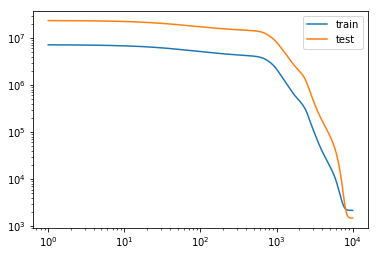

In [6]:
plt.loglog(train_loss_hist, label='train')
plt.loglog(test_loss_hist, label='test')
plt.legend()

# Speeding it up
The simple solution we have so far assumes that loss is computed by materializing the full estimated tensor and then zeroing out unobserved elements. If the tensors are really large and the fraction of observerd values is small (e.g. less than 1%), it may be much more efficient to directly work only with the observed elements.

In [27]:
# Since now the tensor is too large to work with,
# we don't want to generate binary mask,
# but we would rather generated indecies of obsrved cells.
num_values_total = np.prod(shape)
num_observed_values = int(0.3 * num_values_total)
np.random.seed(0)
observed_indices = np.random.choice(num_values_total, size=num_observed_values, replace=False)
observed_values = tf.gather(tf.reshape(noisy_ground_truth, [-1]), observed_indices)
# TODO: implement t3f.gather and compute estimated_values.
# fast_train_loss = tf.matmul(tf.transpose(observed_values), estimated_values)